# SpikeInterface v0.101.2 - Adapted by Rodrigo Noseda - October 2024

SpikeInterface to analyze a multichannel dataset from Cambridge Neurotech Probes. 
The dataset is extracted using open-ephys DAQ and Bonsai-rx (in .bin).
Event_timestamps need some work.

# 0. Preparation <a class="anchor" id="preparation"></a>

In [1]:
import spikeinterface.full as si
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import os
import glob
import warnings
warnings.simplefilter("ignore")
%matplotlib widget
print(f"SpikeInterface Version: {si.__version__}")

SpikeInterface Version: 0.101.2


# 1. Loading saved recording and probe information <a class="anchor" id="loading"></a>

In [2]:
# Setting file paths and basic parameters
base_folder = Path('D:/Ephys_C2DRG/')
data_folder = Path("D:/Ephys_C2DRG/2023_9_21/")

# parameters associated to the recording in bin format
num_channels = 64 #must know apriori; modify in probe below accordingly.
fs = 30000
gain_to_uV = 0.195
offset_to_uV = 0
rec_dtype = "float32"
time_axis = 0     
time_format = "%H:%M:%S.%f"
n_cpus = os.cpu_count()
n_jobs = n_cpus - 2 #n_jobs = -1 :equal to the number of cores.
job_kwargs = dict(n_jobs=n_jobs, chunk_duration="1s", progress_bar=True)

# Loading filtered and cleaned recording from binary saved.
recording_filename = data_folder / 'recording_clean' / 'traces_cached_seg0.raw'
recording_loaded = si.read_binary(recording_filename, num_chan=num_channels,sampling_frequency=fs,
                           dtype=rec_dtype, gain_to_uV=gain_to_uV, offset_to_uV=offset_to_uV, 
                           time_axis=time_axis, is_filtered=True)
#recording_loaded = si.load_extractor(file_or_folder, base_folder)

ProbeInterface version: 0.2.24


(-60.0, 300.0)

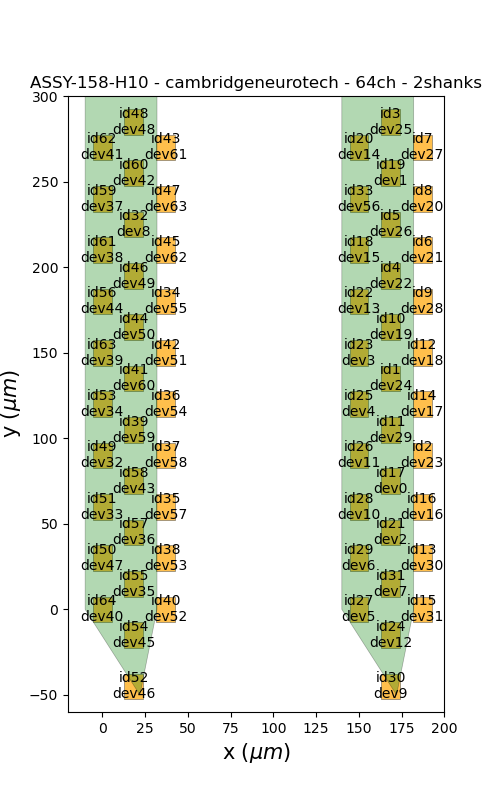

In [3]:
#Get probe from library and set channel mapping
import probeinterface as pi
from probeinterface.plotting import plot_probe
print(f"ProbeInterface version: {pi.__version__}")
manufacturer = 'cambridgeneurotech'
probe_name = 'ASSY-158-H10' #probe_name = 'ASSY-158-F' #probe_name = 'ASSY-158-H6'
probeH10 = pi.get_probe(manufacturer, probe_name)#library: comes with contact_ids and shank_ids info.

#Mapping Intan (device) channels
device_channel_indices = [24,23,25,22,26,21,27,20,28,19,29,18,30,17,31,16,0,15,1,14,2,13,3,12,4,11,5,10,6,9,7,8,
    56,55,57,54,58,53,59,52,60,51,61,50,62,49,63,48,32,47,33,46,34,45,35,44,36,43,37,42,38,41,39,40] #Modify accordingly.
#   88,87,89,86,90,85,91,84,92,83,93,82,94,81,95,80,64,79,65,78,66,77,67,76,68,75,69,74,70,73,71,72,
#   120,119,121,118,122,117,123,116,124,115,125,114,126,113,127,112,96,111,97,110,98,109,99,108,100,107,101,106,102,105,103,104]
#Setting Intan channels to probe(RHD-2132/2164)
probeH10.set_device_channel_indices(device_channel_indices)
fig, ax = plt.subplots(figsize=(5, 8))
plot_probe(probeH10, ax=ax, with_contact_id=True, with_device_index=True,)
ax.set_xlim(-20, 200)
ax.set_ylim(-60, 300)

In [4]:
#Set and group by shank probe before sorting
recording_clean_prb = recording_loaded.set_probe(probeH10, group_mode="by_probe")
recordings_by_group = recording_clean_prb.split_by("group")
recording_to_process = recordings_by_group[0]
#recording_to_process = recording_to_process.time_slice(start_time=0, end_time=600)

#Load times from timestamps csv files and calculate start time in seconds.
tms_files = sorted(glob.glob(os.path.join(data_folder, "Timestamps*.csv")))
concatenated_start_times = pd.DataFrame()
for tms_file in tms_files:
    df = pd.read_csv(tms_file, header=None, nrows=1, names=['Start_Times'])#(usecols=[0], nrows=1)
    df['Start_Times'] = df['Start_Times'].str.slice(0, 15)#first = df.head(1) #last = df.tail(1)
    concatenated_start_times = pd.concat([concatenated_start_times, df], ignore_index=True)
concatenated_start_times['Start_Times'] = pd.to_datetime(concatenated_start_times['Start_Times'])
time_diff = concatenated_start_times['Start_Times'] - concatenated_start_times['Start_Times'].iloc[0]
seconds_start = time_diff.dt.total_seconds()
#print(seconds_start)

#Get and set time vector, and confirm recording_to_process features
for i in range(recording_to_process.get_num_segments()):
    s = recording_to_process.get_num_samples(segment_index=i)
    d = recording_to_process.get_duration(segment_index=i)
    t = recording_to_process.get_times(segment_index=i)
    p = recording_to_process.has_probe()
    tms_temp = t + seconds_start[i]
    tms = recording_to_process.set_times(tms_temp, segment_index=i, with_warning=True)
    tv = recording_to_process.has_time_vector(segment_index=i)
    print(f"Segment {i}: Duration: {d} sec - Samples: {s} - Has time vector?: {tv} - Has Probe?: {p} - Time Vector: {t}")

Segment 0: Duration: 10799.594 sec - Samples: 323987820 - Has time vector?: True - Has Probe?: True - Time Vector: [0.00000000e+00 3.33333333e-05 6.66666667e-05 ... 1.07995939e+04
 1.07995939e+04 1.07995940e+04]


# 3. Spike sorting <a class="anchor" id="spike-sorting"></a>

In [ ]:
from pprint import pprint
default_KS4_params = si.get_default_sorter_params('kilosort4')
# Parameters can be changed by single arguments: 
default_KS4_params['batch_size'] = 150000 #5 sec
default_KS4_params['nblocks'] = 0 
default_KS4_params['Th_universal'] = 8
default_KS4_params['Th_learned'] = 7
default_KS4_params['nearest_chans'] = 10 
default_KS4_params['nearest_templates'] = 32
#default_KS4_params['artifact_threshold'] = 10
default_KS4_params['dmin'] = 30
default_KS4_params['dminx'] = 30
default_KS4_params['min_template_size'] = 10
default_KS4_params['scale'] = 3
#default_KS4_params['do_CAR'] = True
default_KS4_params['skip_kilosort_preprocessing'] = False
default_KS4_params['do_correction'] = True
default_KS4_params['duplicate_spike_ms'] = 0.5
sorter_params = default_KS4_params
pprint(default_KS4_params)

In [ ]:
#Run spike sorting on recording using docker container
sorting_KS4 = si.run_sorter('kilosort4', recording_to_process, folder=data_folder / 'sorting_KS4',
                            docker_image=True, verbose=True, **sorter_params)#, **job_kwargs)
print(sorting_KS4)

In [ ]:
w_rs = si.plot_rasters(sorting_KS4, time_range=(0, 590), backend='matplotlib')

In [5]:
sorting_KS4 = si.read_kilosort(data_folder / 'sorting_KS4' / 'sorter_output')
#sa = si.load_sorting_analyzer(data_folder / 'sorting_analyzer_KS4')

# 6. Postprocessing: SortingAnalyzer <a class="anchor" id="sortinganalyzer"></a>

The core module uses `SortingAnalyzer` for postprocessing computation from paired recording-sorting objects. It retrieves waveforms, templates, spike amplitudes, etc.

In [6]:
sparsity = si.estimate_sparsity(sorting_KS4,recording_to_process, num_spikes_for_sparsity=100, method="radius",
                               radius_um=100, peak_sign="neg", amplitude_mode="extremum")
print(sparsity)

estimate_sparsity:   0%|          | 0/10800 [00:00<?, ?it/s]

ChannelSparsity - units: 45 - channels: 64 - density, P(x=1): 0.25


In [7]:
sa = si.create_sorting_analyzer(sorting_KS4, recording_to_process, folder=data_folder / "sorting_analyzer_KS4", 
                              format="binary_folder", sparsity=sparsity, overwrite=True, **job_kwargs)

#### Computing Extensions: PCA, waveforms, templates, spike amplitude, correlograms, etc.

Let's move on to explore the postprocessing capabilities of the `postprocessing` module. Similarly to the `SortingAnalizer` object, the method 'compute` retrieve info on demand.

In [ ]:
#SortingAnalizer computations: each call will recompute and overwrite previous computations
rand = sa.compute("random_spikes", method="uniform", max_spikes_per_unit=500)#subsample to create a template
wf = sa.compute("waveforms", ms_before=1.0, ms_after=2.0, **job_kwargs)
templ =sa.compute("templates", ms_before=1.0, ms_after=2.0, operators=["average", "std"])#from raw waveforms or random_spikes
spk_amp = sa.compute("spike_amplitudes", peak_sign="neg")#based on templates
noise = sa.compute("noise_levels")
#amp_scal = sa.compute("amplitude_scalings")#per channel
pca = sa.compute("principal_components", n_components=3, mode="by_channel_local")#, whiten=False, dtype='float32')
corr = sa.compute("correlograms", window_ms=50.0, bin_ms=1.0, method="auto")
isi = sa.compute("isi_histograms", window_ms=50.0, bin_ms=1.0, method="auto")
spk_loc = sa.compute("spike_locations", ms_before=0.5, ms_after=0.5, method="center_of_mass")#method="monopolar_triangulation"(slow but more acccurate) #need for drift metrics (drift_ptp, drift_std, drift_mad)
templ_sim = sa.compute("template_similarity", method="cosine_similarity", )#need for spikeinterface_gui. Not well suited for high-density probes!
u_loc = sa.compute("unit_locations", method='center_of_mass')#method="monopolar_triangulation")
#templ_metric = sa.compute("template_metrics", include_multi_channel_metrics=True) #good when analyzing spike shapes, depolarization slope, etc. 
#qm = sa.compute("quality_metrics")

compute_waveforms:   0%|          | 0/10800 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/10800 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/45 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/45 [00:00<?, ?it/s]

spike_locations:   0%|          | 0/10800 [00:00<?, ?it/s]

# 7. Quality Metrics <a class="anchor" id="qualitymetrics"></a>

#### Metrics for Spikes

In [ ]:
si.get_default_qm_params()

In [9]:
#Amplitud cutoff (calculate the approximate fraction of missing spikes) - Need "spike_amplitudes"
fraction_missing = si.compute_amplitude_cutoffs(sa)

#Amplitud CV (coefficient of variation) - Need "spike_amplitudes" or "amplitude_scalings" pre-computed.
amplitude_cv_median, amplitude_cv_range = si.compute_amplitude_cv_metrics(sa) #dicts: unit ids as keys, and amplitude_cv metrics as values.

#Drift metrics - Need "spike_locations"
drift_ptps, drift_stds, drift_mads = si.compute_drift_metrics(sa) #dicts: unit ids as keys, and drifts metrics as values.

#Firing Range (outside of physiological range, might indicate noise contamination)
firing_range = si.compute_firing_ranges(sa) #dict: unit IDs as keys, firing_range as values (in Hz).

#***Firing Rate (average number of spikes/sec within the recording)
firing_rate = si.compute_firing_rates(sa) #dict or floats: unit IDs as keys, firing rates across segments as values (in Hz).

#Inter-spike-interval (ISI) Violations (rate of refractory period violations)
isi_violations_ratio, isi_violations_count = si.compute_isi_violations(sa) #dicts: unit ids as keys, and isi ratio viol and number of viol as values.

#****Refractory period Violations
rp_violation = si.compute_refrac_period_violations(sa)

#Presence Ratio (proportion of discrete time bins in which at least one spike occurred)
presence_ratio = si.compute_presence_ratios(sa) #dict: unit IDs as keys, presence ratio (between 0 and 1) as values.
#Close or > 0.9 = complete units. Close to 0 = incompleteness (type II error) or highly selective firing pattern.

#****Standard Deviation (SD) ratio
sd_ratio = si.compute_sd_ratio(sa) #Close to 1 = unit from single neuron.

#****Signal-to-noise ratio (SNR)
SNRs = si.compute_snrs(sa) #dict: unit IDs as keys and their SNRs as values.
#High SNR = likely to correspond to a neuron. Low SNR = unit contaminated.

#Synchrony Metrics (characterize synchronous events within the same spike train and across different spike trains)
synchrony = si.compute_synchrony_metrics(sa) #tuple of dicts with the synchrony metrics for each unit.

#### Metrics for Clusters

In [ ]:
all_pcs = si.compute_principal_components(sa)

In [ ]:
#Isolation Distance (distance from a cluster to the nearest other cluster)
iso_distance = si.pca_metrics.mahalanobis_metrics(all_pcs=all_pcs, all_labels=all_labels, this_unit_id=0)
#returns floats: iso_distance, l_ratio.

#Nearest Neighbor Metrics (evaluate unit quality)
si.pca_metrics.nearest_neighbors_metrics(all_pcs, all_labels, this_unit_id, max_spikes, n_neighbors)
#Calculate unit contamination based on NearestNeighbors search in PCA space.
si.pca_metrics.nearest_neighbors_isolation(sa)
#Calculate unit isolation based on NearestNeighbors search in PCA space.
si.pca_metrics.nearest_neighbors_noise_overlap(sa)
#Calculate unit noise overlap based on NearestNeighbors search in PCA space.

#D-prime (estimate the classification accuracy between two units)
d_prime = si.lda_metrics(all_pcs=all_pcs, all_labels=all_labels, this_unit_id=0)
#returns a float (larger in well separated clusters)

#Silhouette score (ratio between the cohesiveness of a cluster and its separation from other clusters)
simple_sil_score = si.simplified_silhouette_score(all_pcs=all_pcs, all_labels=all_labels, this_unit_id=0)
#Close to 1 = good clustering. Close to -1 = poorly isolated cluster.

Looking at the metrics on the good units, we can create rules to only keep units that are of sufficient quality. For example:
- A `firing_rate` greater than 1.0 Hz
- A `snr` greater than 1.1
- A `rp_contamination` below 20%
- A `sd_ratio` below 1.5

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):
and then we can use the query to select units:

In [ ]:
#If I know quality of units, add them below.
good_unit_ids = np.array([3, 13, 19, 34, 39, 40, 41], dtype=np.int32)
ok_unit_ids = np.array([11, 18, 22, 51], dtype=np.int32)

In [ ]:
rule = "firing_rate > 1.0 & snr > 1.1  & rp_contamination < 0.2 & sd_ratio < 1.5"
good_metrics = qm.query(rule)
curated_unit_ids = list(good_metrics.index)
print(curated_unit_ids)

In [ ]:
curated_sorting = sorting_KS4.select_units(curated_unit_ids)
curated_analyzer = sa.select_units(curated_unit_ids)
curated_sorting

In [ ]:
pairs = si.get_potential_auto_merge(curated_analyzer)
pairs

In [ ]:
for pair in pairs:
    si.plot_crosscorrelograms(sa, unit_ids=pair, min_similarity_for_correlograms=None, backend="matplotlib")

# 9. Export to Phy for manual curation <a class="anchor" id="exporters"></a>
#### [Phy](https://github.com/cortex-lab/phy). 

In [ ]:
si.export_to_phy(sa, output_folder=data_folder / 'phy_KS4_RN', compute_pc_features=True,
                   copy_binary=True, dtype='float32', compute_amplitudes=True,
                   sparsity=sparsity, add_quality_metrics=True, add_template_metrics=True, 
                   template_mode='median', verbose=True,**job_kwargs)

write_binary_recording:   0%|          | 0/10800 [00:00<?, ?it/s]

extract PCs:   0%|          | 0/10800 [00:00<?, ?it/s]